# Assignment-2 Annie Zhou
* For the assignment, in Task 1, I optimized the sample code, improving the accuracy from 85% to 89%.

* The parts `import and squeeze data` and `Convert waveforms to spectrograms` were the same as in the sample code. To save runtime, I removed the plotting of spectrograms and waveforms.

* In Task 2, I tried both autoencoder CNN and DNN methods, with accuracies of 87% and 88%.
* Reference open-source implementations:
[Voice classification through MFCC features and
DNN Testing](https://medium.com/@voicecityorg/voice-classification-through-mfcc-features-and-dnn-testing-7d26f4888248)

In [1]:
!pip install -U -q tensorflow tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00


In [41]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from IPython import display
import itertools

import librosa

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Import and squeeze data


In [63]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [64]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['go' 'left' 'down' 'no' 'right' 'stop' 'yes' 'up']


In [65]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [66]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [67]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [68]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [69]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


# Convert waveforms to spectrograms

In [70]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [71]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [72]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Optimize CNN model from sample
*   `padding ='same'` in the convolutional layers,ensures that the spatial dimensions of the output feature maps remain consistent with the input, which can help preserve important features in the images.
*   extra convolutional layer with `128` filters, increasing the model's capacity to learn more complex patterns.

*   adjusted the max pooling and dropout layers. I implemented max pooling after each convolutional layer, which helps reduce the dimensionality of the feature maps, leading to a more compact and computationally efficient model.    
*   The dropout rates were carefully recalibrated. While the first dropout layer remained at `0.25`, second dropout layer with a rate of `0.3` before the final set of layers. This helps prevent overfitting by randomly deactivating a proportion of neurons during training, encouraging the model to learn more robust features.

*   Finally, I modified the activation function in the last dense layer to `softmax`. This change is crucial for multi-class classification tasks, as `softmax` provides a set of probabilities for each class, ensuring that the output probabilities sum to one.

In [73]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [74]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [75]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the normalization layer
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])



Input shape: (124, 129, 1)


In [76]:
# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # adjust learning rate
    # remove the "from_logits=True", because last dense layer is `softmax`
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [77]:
EPOCHS = 20 # add 5 more epochs
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2,restore_best_weights=True),
)

Epoch 1/20
100/100 [==============================] - 4s 16ms/step - loss: 1.9287 - accuracy: 0.2692 - val_loss: 1.6167 - val_accuracy: 0.4740
Epoch 2/20
100/100 [==============================] - 1s 7ms/step - loss: 1.4642 - accuracy: 0.4748 - val_loss: 1.1368 - val_accuracy: 0.6029
Epoch 3/20
100/100 [==============================] - 1s 6ms/step - loss: 1.1051 - accuracy: 0.5920 - val_loss: 0.9268 - val_accuracy: 0.7044
Epoch 4/20
100/100 [==============================] - 1s 7ms/step - loss: 0.9248 - accuracy: 0.6542 - val_loss: 0.7011 - val_accuracy: 0.7734
Epoch 5/20
100/100 [==============================] - 1s 6ms/step - loss: 0.7732 - accuracy: 0.7147 - val_loss: 0.6143 - val_accuracy: 0.8060
Epoch 6/20
100/100 [==============================] - 1s 8ms/step - loss: 0.6812 - accuracy: 0.7536 - val_loss: 0.5517 - val_accuracy: 0.8112
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 0.6140 - accuracy: 0.7827 - val_loss: 0.4879 - val_accuracy: 0.8464
Epoch

In [78]:
# 'accuracy': 0.890625
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 66ms/step - loss: 0.3037 - accuracy: 0.8942


{'loss': 0.30371248722076416, 'accuracy': 0.8942307829856873}

# Visualized CNN model

* From the confusion matrix, it's clear that the
model struggles with predicting the labels `go`, `no`, and `down`.
* Additionally, I noticed that the label order in the sample code was incorrect, so I corrected it to the right sequence.

13/13 [==============================] - 0s 3ms/step


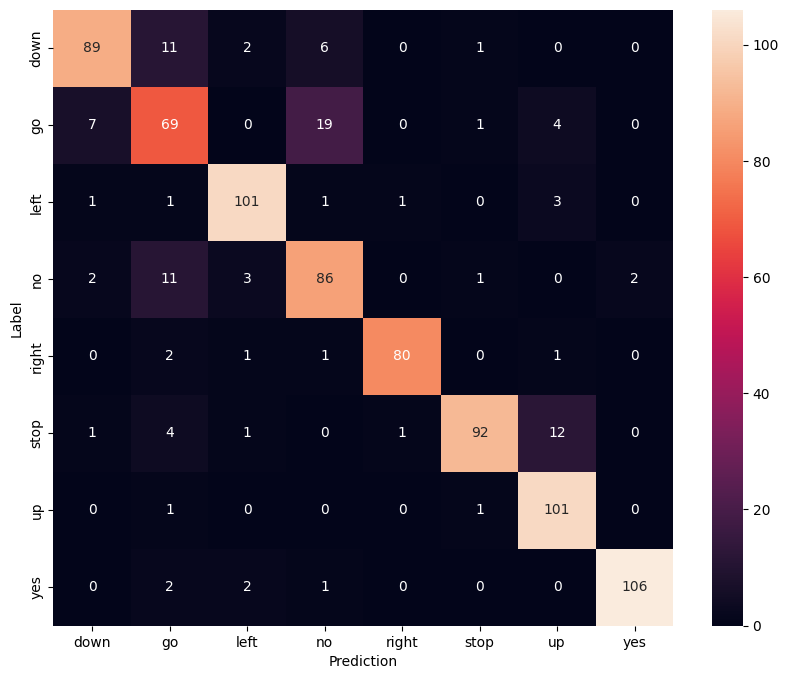

In [19]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Text(0, 0.5, 'Accuracy [%]')

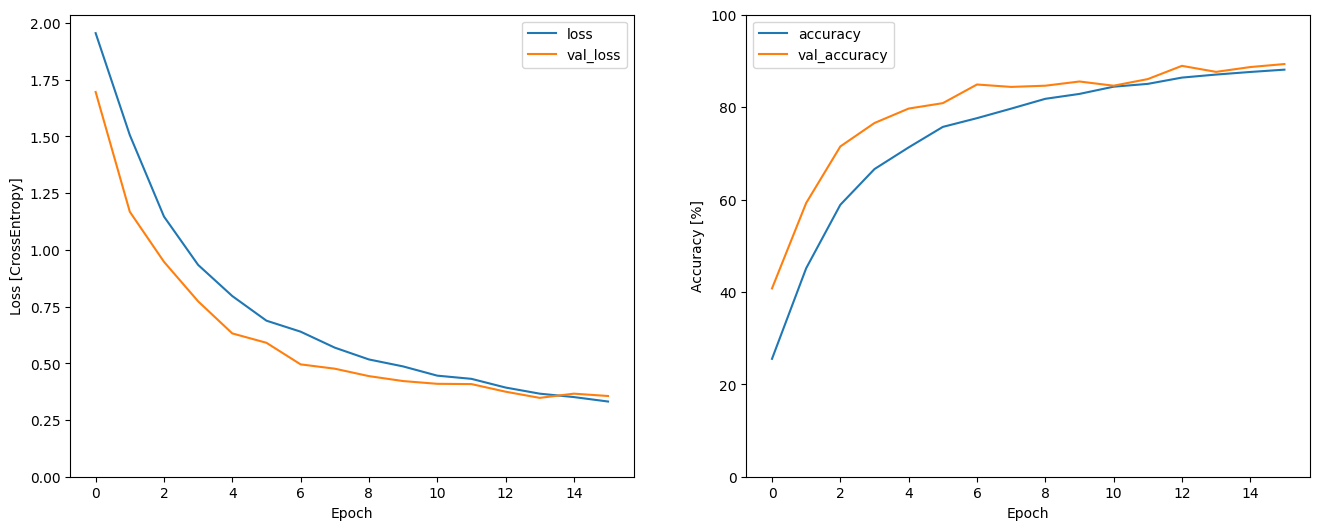

In [20]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

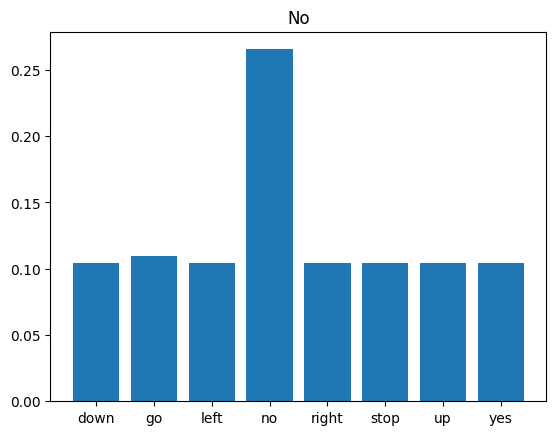

In [21]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Task 2

## Convolutional Autoencoder
* Test Accuracy: 0.88

In [58]:
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

# normlization layer
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

encoder_input = layers.Input(shape=input_shape)

# encoder
encoder_input = layers.Input(shape=input_shape)
x = norm_layer(encoder_input)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
encoded = layers.MaxPooling2D()(x)

# decoder
x = layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(encoded)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# classifier
x = layers.Flatten()(encoded)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0006))(x)
x = layers.Dropout(0.5)(x)
classifier_output = layers.Dense(num_labels, activation='softmax')(x)

# build a convolutional autoencoder model
autoencoder = models.Model(encoder_input,decoded)

# final model including classifier
classifier_model = models.Model(encoder_input, classifier_output)


# autoencoder
autoencoder = models.Model(encoder_input, decoded)

# final model including classifier
final_model = models.Model(encoder_input, classifier_output)

# learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
)

In [59]:
# compile autoencoder
final_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = callbacks.ModelCheckpoint(
    'best_model',
    save_best_only=True,
    monitor='val_loss',
    save_format='tf'
)

history = final_model.fit(
    train_spectrogram_ds,
    epochs=20,
    validation_data=val_spectrogram_ds,
    callbacks=[early_stopping, model_checkpoint]
)

# load best model
final_model = tf.keras.models.load_model('best_model')

# evaluate model
test_loss, test_accuracy = final_model.evaluate(test_spectrogram_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# use model to predict
predictions = final_model.predict(test_spectrogram_ds)


Epoch 1/20
100/100 [==============================] - 6s 44ms/step - loss: 1.7732 - accuracy: 0.4116 - val_loss: 1.1017 - val_accuracy: 0.7109
Epoch 2/20
100/100 [==============================] - 4s 40ms/step - loss: 1.0526 - accuracy: 0.7045 - val_loss: 0.7685 - val_accuracy: 0.7995
Epoch 3/20
100/100 [==============================] - 4s 44ms/step - loss: 0.7633 - accuracy: 0.8047 - val_loss: 0.6406 - val_accuracy: 0.8685
Epoch 4/20
100/100 [==============================] - 4s 40ms/step - loss: 0.6507 - accuracy: 0.8478 - val_loss: 0.5771 - val_accuracy: 0.8893
Epoch 5/20
100/100 [==============================] - 4s 40ms/step - loss: 0.5814 - accuracy: 0.8753 - val_loss: 0.5626 - val_accuracy: 0.8828
Epoch 6/20
100/100 [==============================] - 4s 45ms/step - loss: 0.5285 - accuracy: 0.8989 - val_loss: 0.5534 - val_accuracy: 0.8854
Epoch 7/20
100/100 [==============================] - 4s 40ms/step - loss: 0.4888 - accuracy: 0.9061 - val_loss: 0.5382 - val_accuracy: 0.9089

Text(0, 0.5, 'Accuracy [%]')

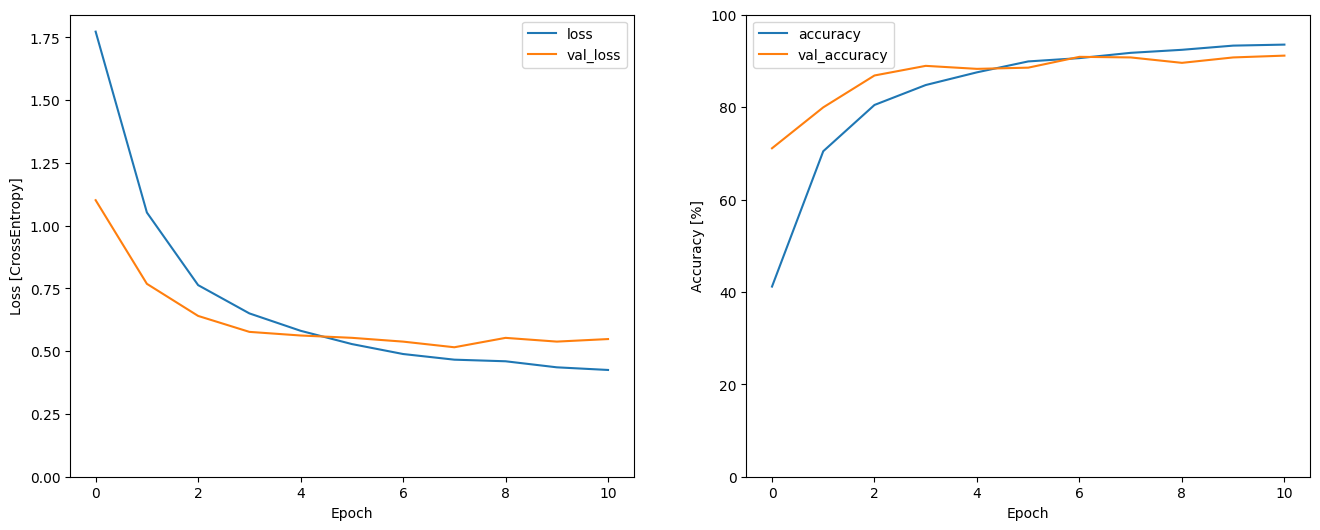

In [60]:
# autoencoder result plot
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

This confusion matrix was generated by GPT-3.0.

Confusion matrix, without normalization


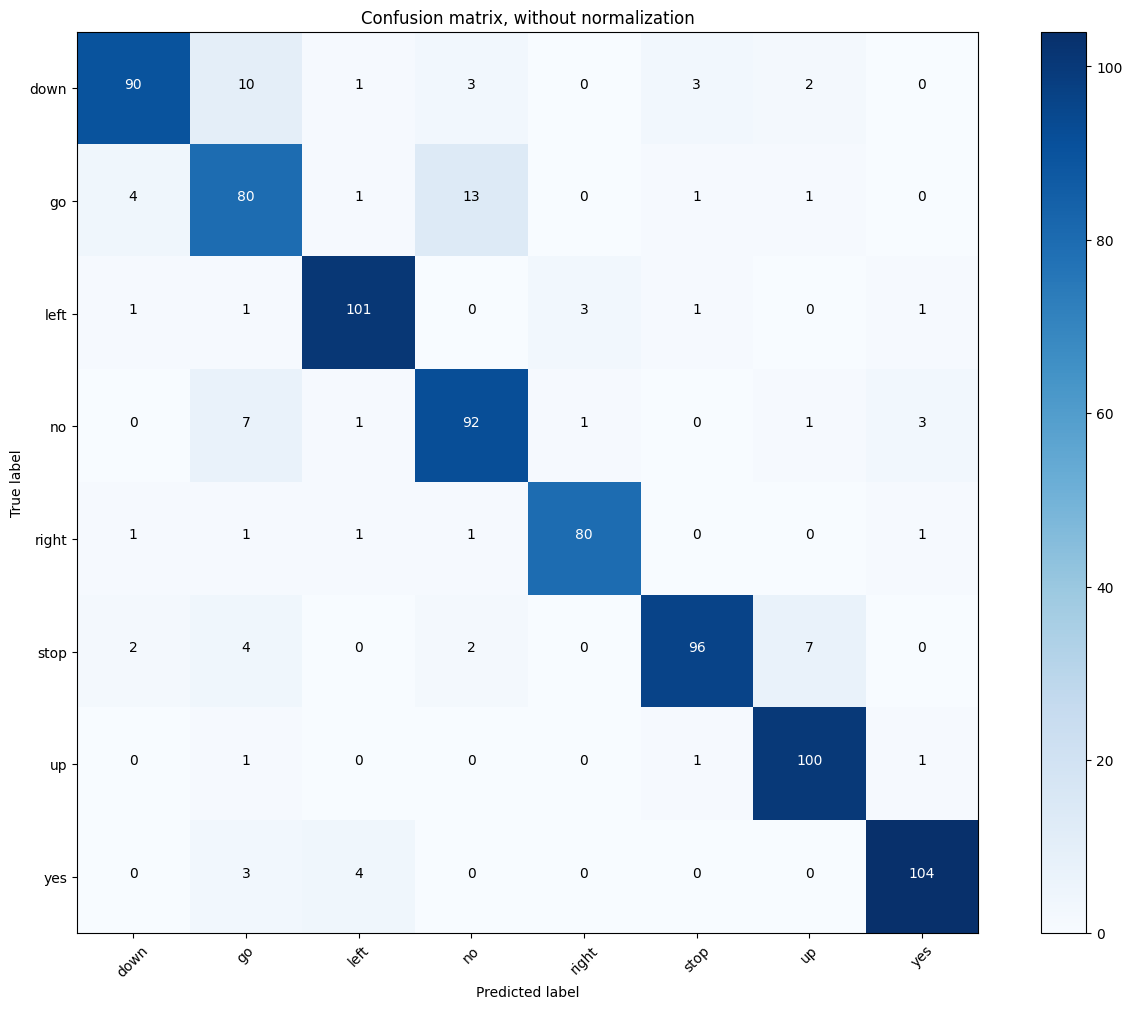

In [61]:
# extract the feature from the encoder
y_true = []
for _, label in test_spectrogram_ds:
    y_true.extend(label.numpy())

# convert prediction to class
y_pred = np.argmax(predictions, axis=1)

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    this function print and plot the confusion matrix
    `normalize=True` to set the normalization
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# class names
class_names = ['down' ,'go' ,'left', 'no' ,'right' ,'stop', 'up' ,'yes']

# plot non-normalized confusion matrix
plt.figure(figsize=(13,10))
plot_confusion_matrix(cm, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

plt.show()

## DNN
* Test Accuracy: 0.88


Extracted MFCCs (Mel Frequency Cepstral Coefficients) from all audio files. To improve accuracy, MFCCs, their first-order derivatives (MFCCs_delta), second-order derivatives (MFCCs_delta2), and labels are also extracted.

In [22]:
def extract_mfcc(file_path, sr=16000, n_mfcc=20, mfcc_max_length=44):
    # load audio
    audio, _ = librosa.load(file_path, sr=sr)

    # culculate MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # calculate delta & delta-delta of MFCC
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

    # make all MFCCs same length
    def pad_or_truncate(mfcc_feature, max_length):
        if mfcc_feature.shape[1] < max_length:
            pad_width = max_length - mfcc_feature.shape[1]
            mfcc_feature = np.pad(mfcc_feature, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc_feature = mfcc_feature[:, :max_length]
        return mfcc_feature

    mfccs = pad_or_truncate(mfccs, mfcc_max_length)
    mfccs_delta = pad_or_truncate(mfccs_delta, mfcc_max_length)
    mfccs_delta2 = pad_or_truncate(mfccs_delta2, mfcc_max_length)

    return mfccs, mfccs_delta, mfccs_delta2

# iterate over the list of audio file paths
mfcc_features = []
for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file)
            mfccs, mfccs_delta, mfccs_delta2 = extract_mfcc(file_path)
            label = subdir  # use the name of subdirectory as the label
            mfcc_features.append((mfccs, mfccs_delta, mfccs_delta2, label))


In [23]:
# perpare data for training
X = []
y = []

for mfccs, mfccs_delta, mfccs_delta2, label in mfcc_features:
    # three features are stacked along the last dimension
    combined_features = np.stack((mfccs, mfccs_delta, mfccs_delta2), axis=-1)
    X.append(combined_features)
    y.append(label)

# turn X and y into numpy arrays
X = np.array(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
# turn y into one-hot vectors
y = to_categorical(y, num_classes=8)

In [24]:
# cheak label encoder classes
class_labels = label_encoder.classes_
print("Label Encoder classes:", class_labels)

# create a dictionary to map labels to index
label_to_index = {label: index for index, label in enumerate(class_labels)}
print("Label to Index Mapping:", label_to_index)

Label Encoder classes: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Label to Index Mapping: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'right': 4, 'stop': 5, 'up': 6, 'yes': 7}


In [25]:
input_shape = X[0].shape
model = models.Sequential([
    layers.Flatten(input_shape=input_shape),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(8, activation='softmax')  # Assuming there are 8 classes
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# two independent StandardScaler objects, one for training data, one for test data
scaler_train = StandardScaler()
scaler_test = StandardScaler()

# reshape training data and test data
X_train_reshaped = np.reshape(X_train, newshape=(-1, X_train.shape[2]))
X_test_reshaped = np.reshape(X_test, newshape=(-1, X_test.shape[2]))

# calculate the mean and std only based on the training data
scaler_train.fit(X_train_reshaped)

# Apply normalization to training data and test data
X_train_scaled = scaler_train.transform(X_train_reshaped)
X_test_scaled = scaler_test.fit_transform(X_test_reshaped)  # Note that different scalers are used here

# reshape standardized data back to original shape
X_train_scaled = np.reshape(X_train_scaled, newshape=X_train.shape)
X_test_scaled = np.reshape(X_test_scaled, newshape=X_test.shape)

# set up learning rate decay
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9 # 10% decay after each 10 epochs

lr_scheduler = callbacks.LearningRateScheduler(scheduler)

#Early stop setting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=4, 
    restore_best_weights=True  #Restore optimal weight
)
#Training model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50, # set a large number of epochs and use early stopping to find optimal number of epochs
    batch_size=64,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
100/100 [==============================] - 4s 10ms/step - loss: 3.2156 - accuracy: 0.3102 - val_loss: 2.4581 - val_accuracy: 0.5387 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 2.3894 - accuracy: 0.5120 - val_loss: 1.9167 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 1s 7ms/step - loss: 2.0562 - accuracy: 0.5884 - val_loss: 1.7120 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 1s 7ms/step - loss: 1.8404 - accuracy: 0.6370 - val_loss: 1.5589 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 1s 7ms/step - loss: 1.7134 - accuracy: 0.6694 - val_loss: 1.4320 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 1s 6ms/step - loss: 1.6054 - accuracy: 0.6891 - val_loss: 1.3614 - val_accuracy: 0.7694 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 1s 7ms/step - l

In [31]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

50/50 [==============================] - 1s 6ms/step - loss: 0.7077 - accuracy: 0.8863
Test accuracy: 0.8862500190734863
Test loss: 0.7076766490936279


Text(0, 0.5, 'Accuracy [%]')

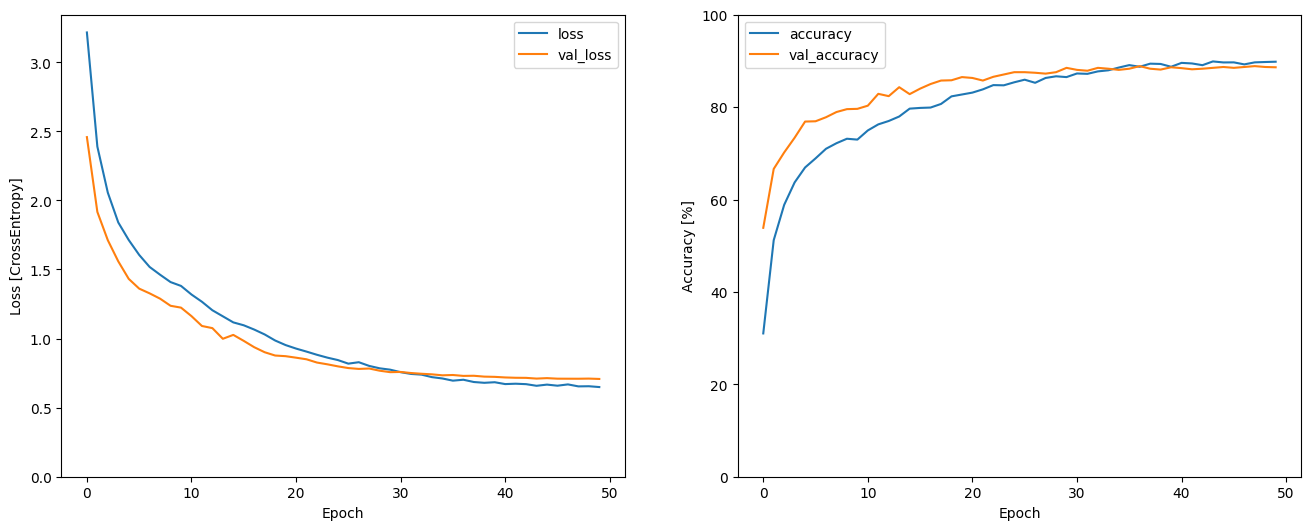

In [27]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

As shown in the figure, the model does not perform well in recognizing the words "no," "go," and "down." I attempted focused training, which improved the model's accuracy in distinguishing these three words, but the overall accuracy significantly decreased. Therefore, I have removed this part.

50/50 [==============================] - 1s 6ms/step


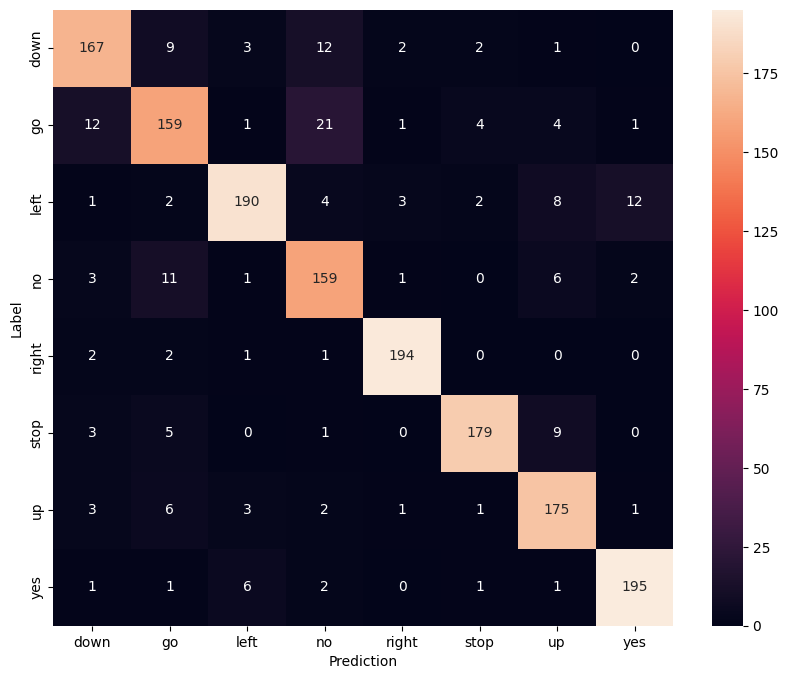

In [45]:
y_pred = model.predict(X_test_scaled)

y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.argmax(y_test, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels= class_labels,
            yticklabels= class_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()